**INTRODUCTION**

The dataset is comprised of 2,178 observations of earthquakes indicating the characteristics of 
- a) geographical position (latitude, longitude), 
- b) depth (focal depth), and  
- c) strength (Richter scale).

The task is to clusterize the observations using several clustering techniques, evaluate them and choose the best one accroding to the chosen metrics. The best clusterization is displayed on a world map. 

**IMPORTS**

In [2]:
import numpy as np
import pandas as pd

import itertools

from scipy.stats import boxcox
from scipy.stats import yeojohnson

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm as tqdm

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px

import descartes
import geopandas as gpd
import geoplot
from shapely.geometry import Point, Polygon

ModuleNotFoundError: No module named 'geoplot'

**FUNCTIONS AND COMMONLY USED CONSTANTS**

In [3]:
def plot_dendrogram(model, **kwargs):
 
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

  dendrogram(linkage_matrix, **kwargs)

**DATASET PREPARATION**

In [4]:
df = pd.read_csv(r'C:\Users\1\Desktop\HW_Classification\quake.csv')

In [5]:
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


Dataset: 2178 observations and 4 numerical features

In [7]:
df.isna().sum()

Focal depth    0
Latitude       0
Longitude      0
Richter        0
dtype: int64

No missing values in the dataset.

**EXPLORATORY DATA ANALYSIS**

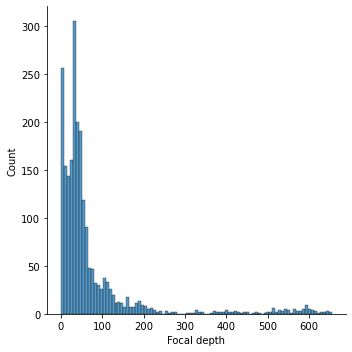

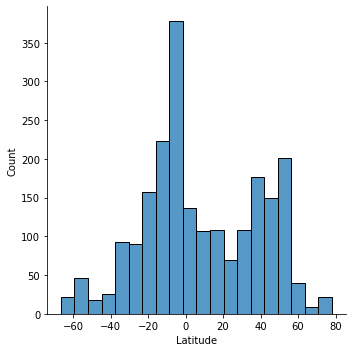

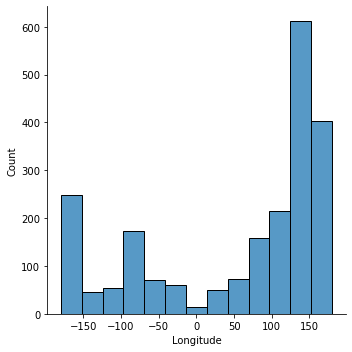

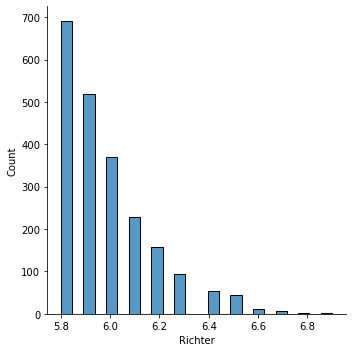

In [8]:
for i in df.columns:
    sns.displot(df[i])

We can see that most of the captured earthquakes are weak ones and/or the ones that occur closer to the earth surface (not deep).  

In [9]:
corr = df.corr()

<AxesSubplot:>

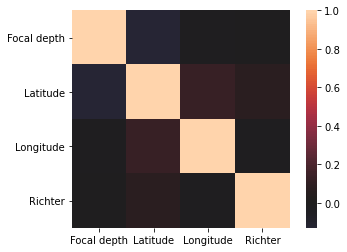

In [10]:
sns.heatmap(corr, center=0, square=True)

There are no significant correlations among the features.

**DATA PREPARATION**

1) Transform the data 

Before scaling the data, it might be useful to use transformations to make it more similar to the normal distribution.  

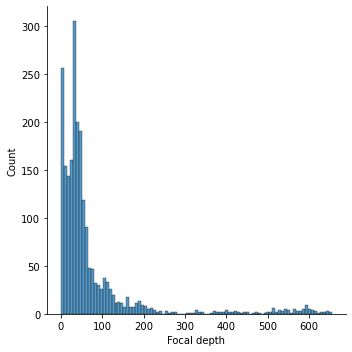

In [11]:
sns.displot(df['Focal depth'])

In [15]:
tr_focal_depth, lam = yeojohnson(df['Focal depth'])

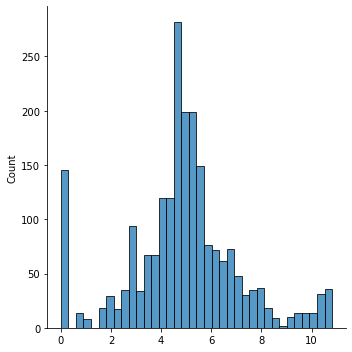

In [16]:
sns.displot(tr_focal_depth)

In [17]:
df['tr_focal_depth'] = tr_focal_depth

2) Scale the data 

Scaling is required since K-means and other clustering algorithms are distance-based, which requires scaling to reflect the distribution of the observations rather than the absolute distance values.

In [18]:
scaler = StandardScaler()

In [19]:
tr_df = df.drop(['Focal depth'], axis=1)
tr_df = scaler.fit_transform(tr_df)

**Clustering 1. K-means**

At first, we will try 15 clusters.

In [20]:
kmeans = KMeans(n_clusters=15, random_state=42)

In [21]:
y_kmeans = kmeans.fit_predict(tr_df)

In [22]:
df['kmeans_label'] = pd.Series(y_kmeans)

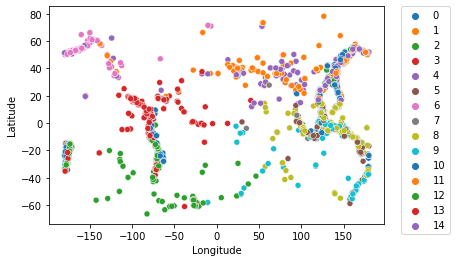

In [23]:
fig = sns.scatterplot(data=df, x=df.Longitude, y=df.Latitude, hue=df['kmeans_label'], palette="tab10")
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.plot();

Now let's try to select the value of k using the Elbow method.

In [24]:
distortions = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tr_df)
    distortions.append(kmeans.inertia_)

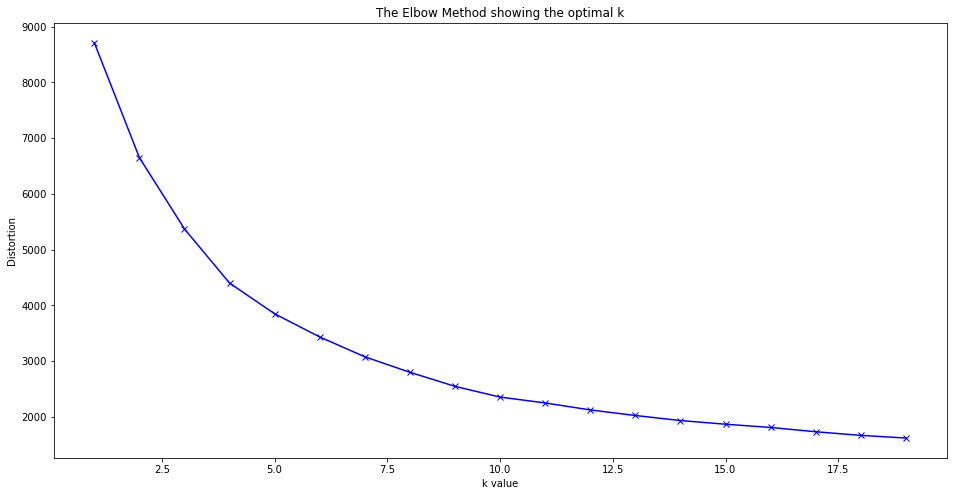

In [25]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k value')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As we can see from the plot, 4 is 'the elbow' meaning that setting the number of clusters to more than 4 will not result in significant descrese of distance between the within-cluster points.

We can also have a ribustness check by computing sihlouette scores for various k-values.

For n_clusters = 2 The average silhouette_score is : 0.29639471521369154
For n_clusters = 3 The average silhouette_score is : 0.28475590910443754
For n_clusters = 4 The average silhouette_score is : 0.30270145677114396
For n_clusters = 5 The average silhouette_score is : 0.27399213317893845
For n_clusters = 6 The average silhouette_score is : 0.2909047648573955


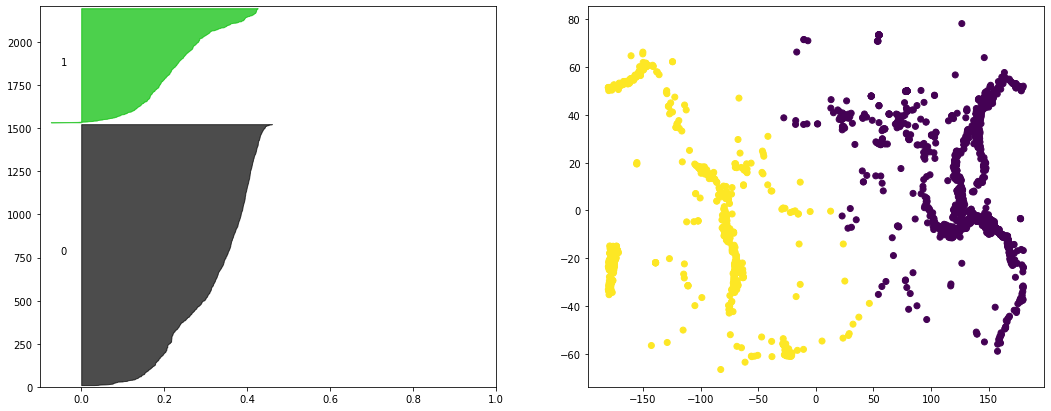

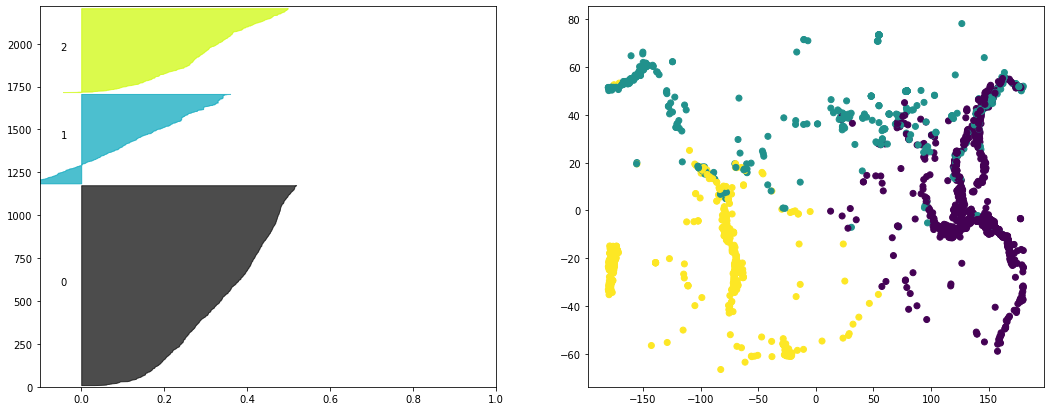

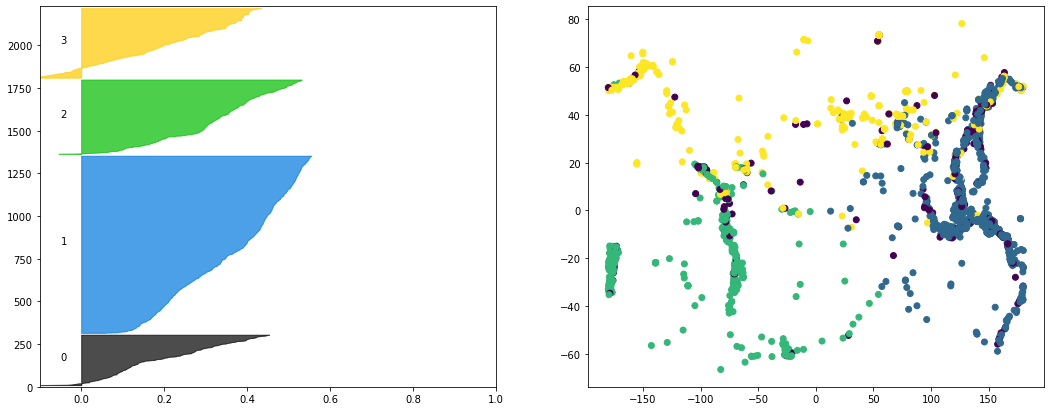

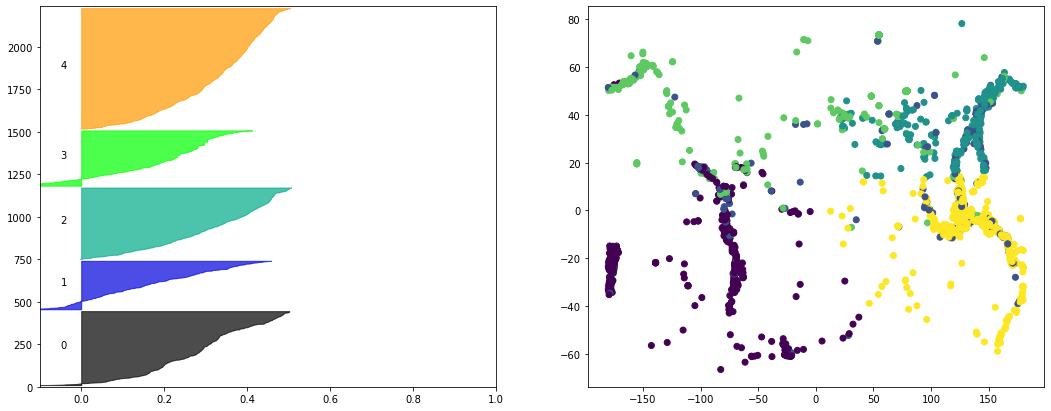

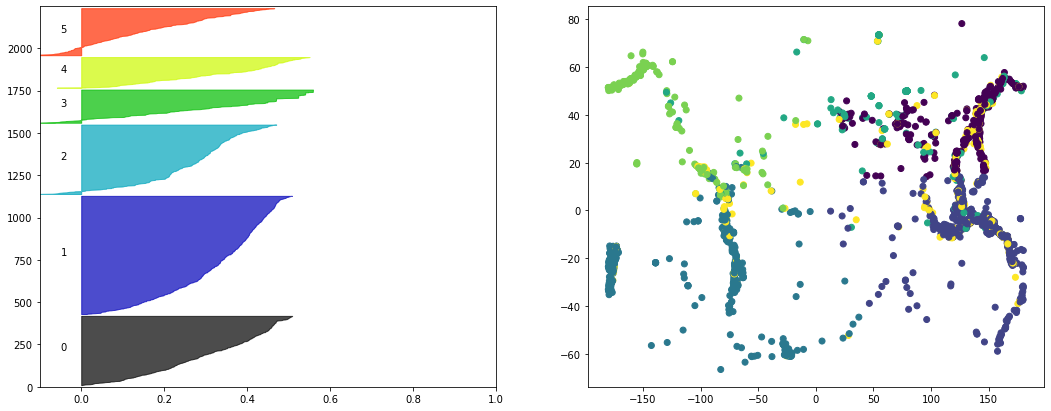

In [26]:
for n_clusters in range(2, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(tr_df)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)


    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(tr_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(tr_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax2.scatter( x=df.Longitude, y=df.Latitude, c=cluster_labels) 

The sihlouette score indicates that 3 is the optimal number of clusters. This is not extremely far from what the Elbow method showed so let's choose 4 as the final number.

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)

In [28]:
y_kmeans = kmeans.fit_predict(tr_df)

In [29]:
df['kmeans_label'] = pd.Series(y_kmeans)

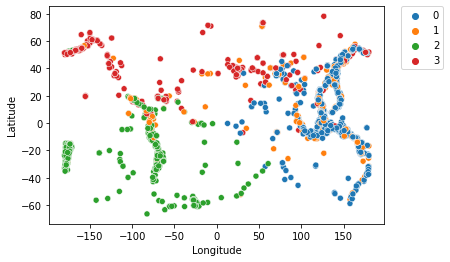

In [30]:
fig = sns.scatterplot(data=df, x=df.Longitude, y=df.Latitude, hue=df['kmeans_label'], palette="tab10")
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.plot();

**Clustering 2. DBSCAN**

Firstly, we will use Nearest Neighbours to find the optimal proximity value of epsilon.

In [31]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(tr_df)
distances, indices = nbrs.kneighbors(tr_df)

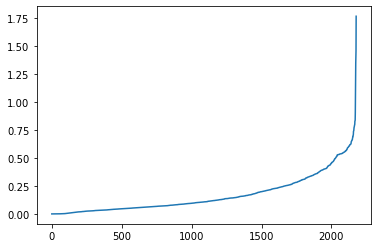

In [32]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Let's train the model with eps=0.6. We will set the min_samples to 8 as a rule of thumb (min_samples = n_dimensions * 2). 

In [33]:
dbscan = DBSCAN(eps=0.6, min_samples=8)

In [34]:
y_dbscan = dbscan.fit_predict(tr_df)

In [35]:
df['dbscan_label'] = pd.Series(y_dbscan)

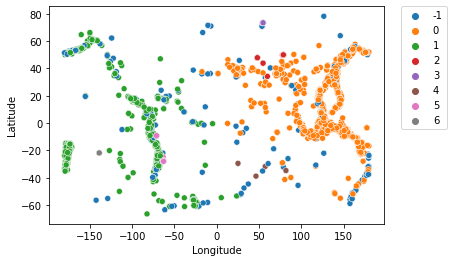

In [36]:
fig = sns.scatterplot(data=df, x=df.Longitude, y=df.Latitude, hue=df['dbscan_label'], palette="tab10")
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.plot();

**Clustering 3. Hierarchical**

Firstly, we will plot the dendogramm to assess the optimal number of clusters.

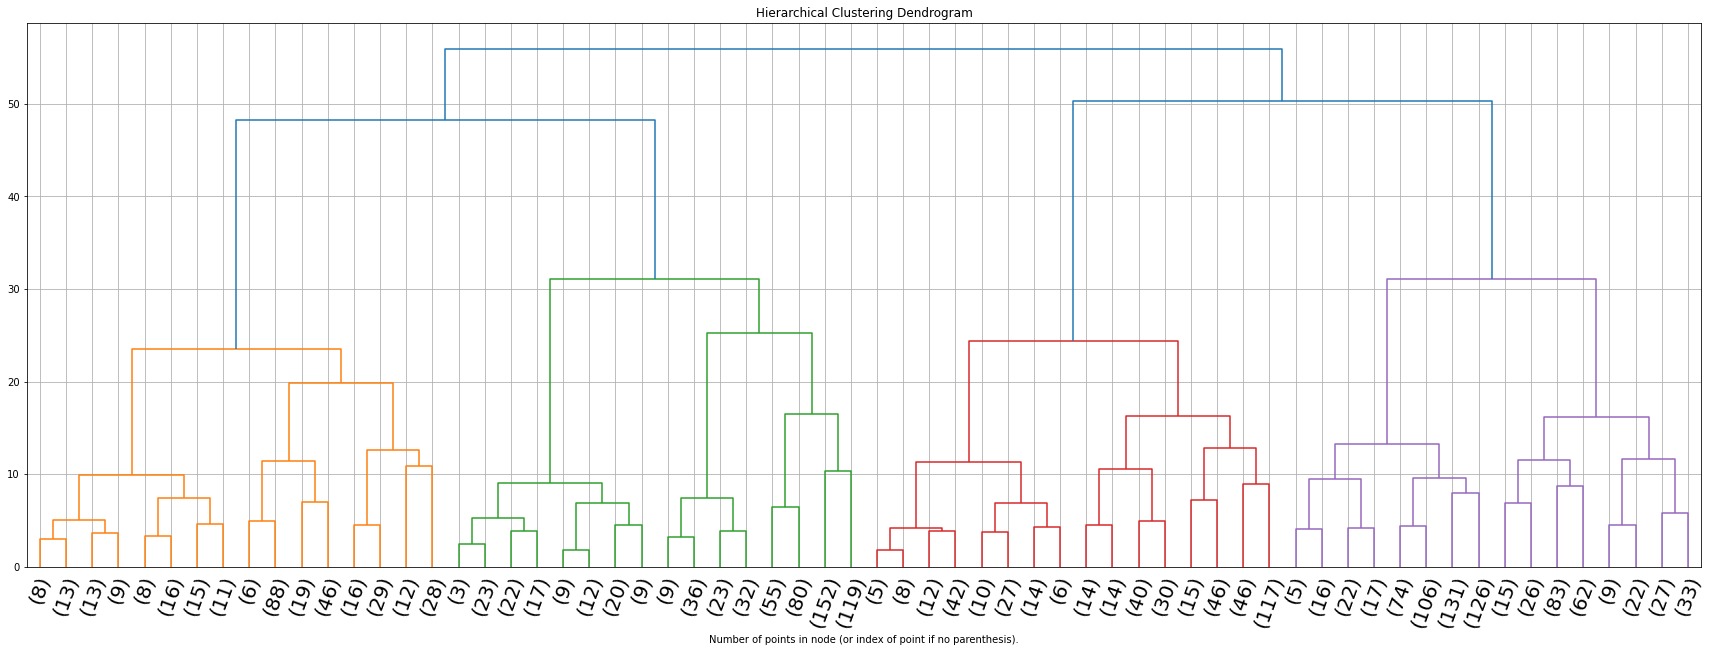

In [37]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(tr_df)
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.grid(True)
plt.xticks(fontsize=20, rotation=70)
plt.show()

The optimal number seems to be 4. Let's train a agglomerative clustering model with 4 clusters.

In [38]:
agglomerative = AgglomerativeClustering(n_clusters=4)

In [39]:
y_agglomerative = agglomerative.fit_predict(tr_df)

In [40]:
df['hierarchical_label'] = pd.Series(y_agglomerative)

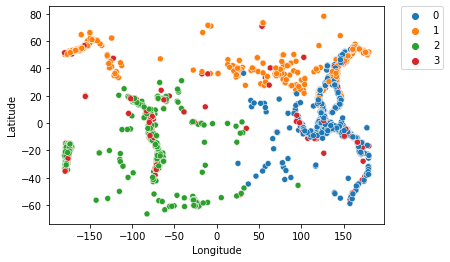

In [41]:
fig = sns.scatterplot(data=df, x=df.Longitude, y=df.Latitude, hue=df['hierarchical_label'], palette="tab10")
fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.plot();

**CHOOSING THE BEST CLUSTERING ALGORITHM**

In [42]:
label_cols = ['dbscan_label', 'hierarchical_label']

Labelled metrics: Rand index, Mutual information score. Using K-means labels as the ground truth. 

In [51]:
for col in label_cols:
    print(f'Adjusted MI score for {col} = {adjusted_mutual_info_score(df["kmeans_label"], df[col])}')
    print(f'Adjusted Rand score for {col} = {adjusted_rand_score(df["kmeans_label"], df[col])}')
    print("")

Adjusted MI score for kmeans_label = 1.0
Adjusted Rand score for kmeans_label = 1.0

Adjusted MI score for dbscan_label = 0.4376152414866562
Adjusted Rand score for dbscan_label = 0.4512281373800788

Adjusted MI score for hierarchical_label = 0.5474095789873744
Adjusted Rand score for hierarchical_label = 0.5277548515750713



According to the labelled metrics with K-means results as the ground truth, agglomerative clustering seems to perform better than DBSCAN. In this context, it means that agglomerative clustering is just most similar to the K-means result. 

Unlabelled metrics: silhouette score, Calinsky-Harabaz score

- Calinsky-Harabaz score

In [52]:
label_cols = ['kmeans_label', 'dbscan_label', 'hierarchical_label']

In [53]:
for col in label_cols:
    print(f'Calinsky-Harabaz score for {col} = {calinski_harabasz_score(tr_df, df[col])}')

Calinsky-Harabaz score for kmeans_label = 709.8251086951128
Calinsky-Harabaz score for dbscan_label = 163.83754804195044
Calinsky-Harabaz score for hierarchical_label = 614.2678797707242


As expected, DBSCAN is reported to have the lowest Calinsky-Harabaz score. K-means is chosen as the best clustering algorithm followed by agglomerative clustering.

- Sihlouette score

In [46]:
for col in label_cols:
    if col == 'kmeans_label':
        cluster_labels = y_kmeans
        
    if col == 'dbscan_label':
        cluster_labels = y_dbscan
        
    if col == 'hierarchical_label':
        cluster_labels = y_agglomerative

    silhouette_avg = silhouette_score(tr_df, cluster_labels)
    print("For ", col,
          "The average silhouette_score is :", silhouette_avg)

For  kmeans_label The average silhouette_score is : 0.2941937915978516
For  dbscan_label The average silhouette_score is : -0.01971309327603574
For  hierarchical_label The average silhouette_score is : 0.2511171750366899


As to the sihlouette score, K-means also leads followed by agglomerative clustering. DBSCAN is shown to have a negative value, which is expected for an algorithm that treats outliers as separate observations that are not included in any cluster. Since sihlouette score assigns negative value to observations that are assigned to a 'wrong' cluster. Since all outliers are distinct points which are on a large distance from one another, they are not treated as the same cluster.

**CONCLUSIONS**

- As seen from the metrics, DBSCAN performs worse than K-means and hierarchical clustering. However, it can be argued that unlabelled metrics are not suited for DBSCAN assessment.
- Nevertheless, even visual examination is not in favour of DBSCAN which produced rather uninterpreteable results on the map.
- The best technique in terms of visual interpretation is K-means clustering. Compared to agglomerative clustering, it preserves outliers as a separate group which is clearly seen in blue dots that are distinct sole earthquakes in the oceans.